Number of samples:  200000
Signal frequencies: 2.0 MHz and 25.0 MHz


<IPython.core.display.Javascript object>


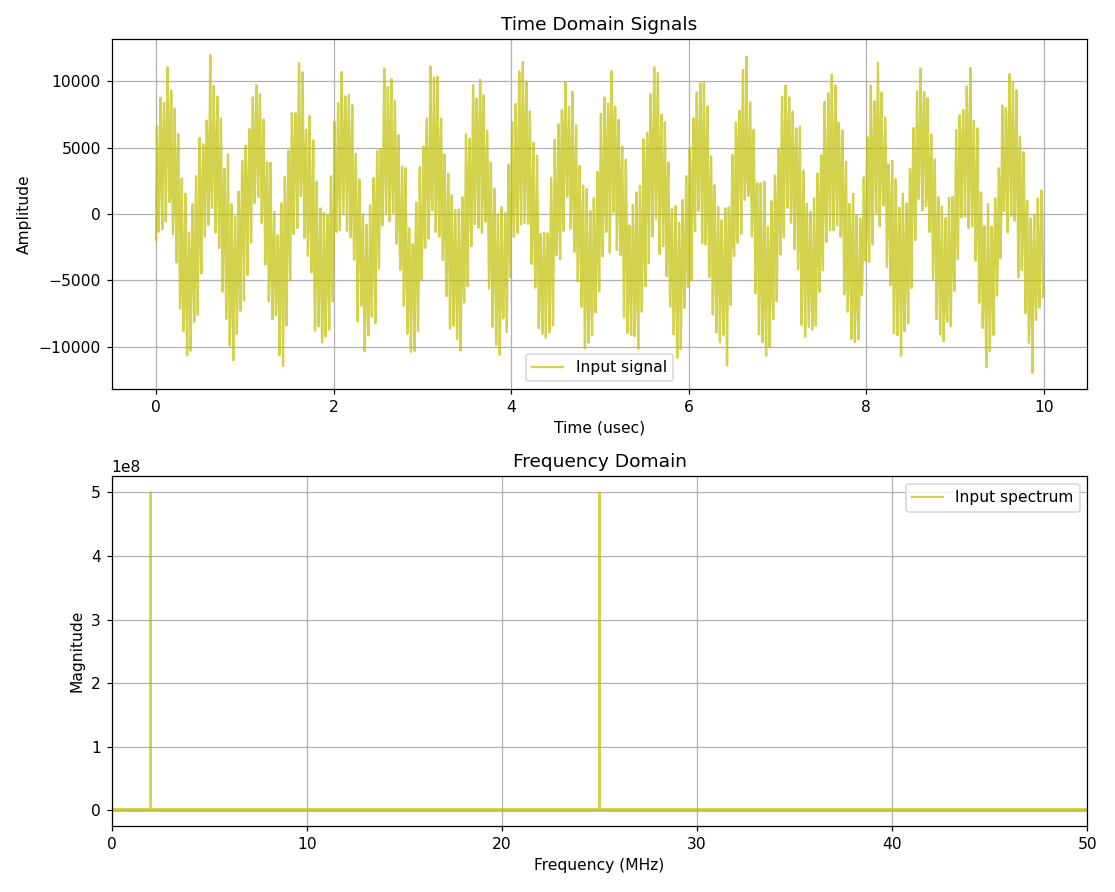

Software FIR execution time:  0.08487772941589355


<IPython.core.display.Javascript object>


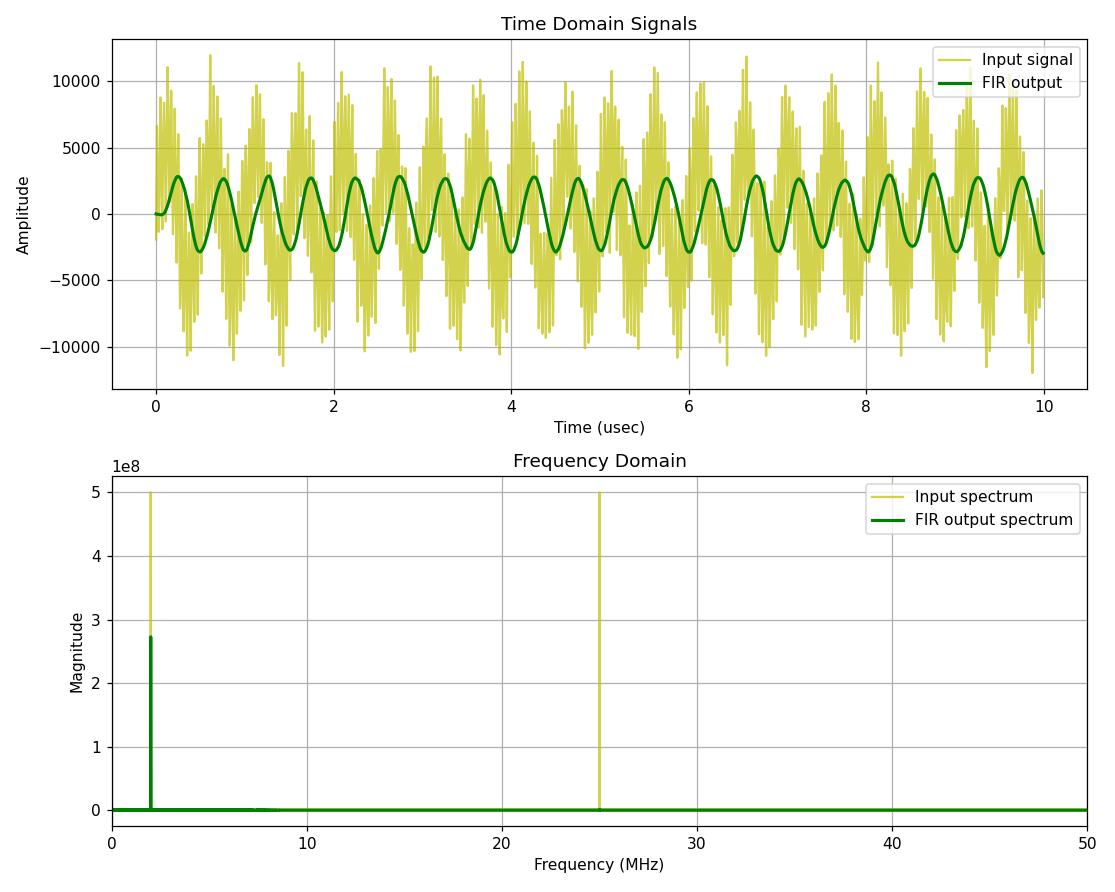

Hardware FIR execution time:  0.007535219192504883
Hardware acceleration factor:  11.264135421610504


<IPython.core.display.Javascript object>


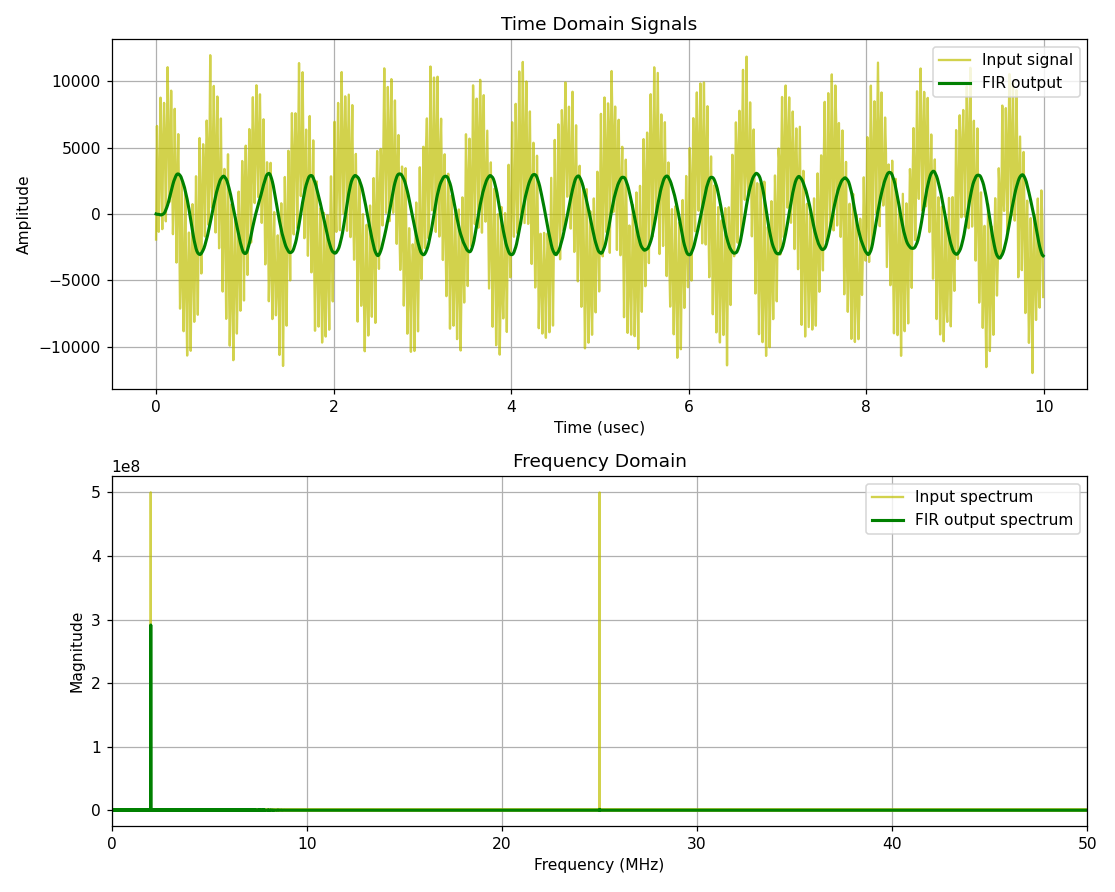


Frequency analysis:
Low frequency component: 2.0 MHz (should pass through filter)
High frequency component: 25.0 MHz (should be attenuated)


In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter
import time
from pynq import Overlay
from pynq import allocate

def plot_signals_and_spectrum(time_sec, in_signal, n_samples, out_signal=None, fs=100e6):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Time domain plot
    ax1.set_xlabel('Time (usec)')
    ax1.set_ylabel('Amplitude')
    ax1.grid()
    ax1.plot(time_sec[:n_samples]*1e6, in_signal[:n_samples], 'y-', label='Input signal', alpha=0.7)
    if out_signal is not None:
        ax1.plot(time_sec[:n_samples]*1e6, out_signal[:n_samples], 'g-', linewidth=2, label='FIR output')
    ax1.legend()
    ax1.set_title('Time Domain Signals')
    
    # Frequency domain plot
    ax2.set_xlabel('Frequency (MHz)')
    ax2.set_ylabel('Magnitude')
    ax2.grid()
    
    # Compute FFT of input signal
    fft_input = np.fft.fft(in_signal)
    freqs = np.fft.fftfreq(len(in_signal), 1/fs) / 1e6  # Convert to MHz
    ax2.plot(freqs[:len(freqs)//2], np.abs(fft_input[:len(fft_input)//2]), 
             'y-', alpha=0.7, label='Input spectrum')
    
    # Compute FFT of output signal if available
    if out_signal is not None:
        fft_output = np.fft.fft(out_signal)
        ax2.plot(freqs[:len(freqs)//2], np.abs(fft_output[:len(fft_output)//2]), 
                 'g-', linewidth=2, label='FIR output spectrum')
    
    ax2.legend()
    ax2.set_title('Frequency Domain')
    ax2.set_xlim(0, 50)  # Focus on relevant frequency range
    
    plt.tight_layout()
    return fig

# Parameters for DTMF signal generation
# Total time
T = 0.002
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)

# DTMF frequencies (example: key '1' - 697 Hz and 1209 Hz)
# But we'll use higher frequencies to demonstrate the filter better
f1 = 2e6   # 2 MHz - should pass through LPF
f2 = 25e6  # 25 MHz - should be attenuated by LPF

# Generate DTMF-like signal
dtmf_signal = 5000*np.sin(f1*2*np.pi*t) + 5000*np.sin(f2*2*np.pi*t)

# Add some noise to make it more realistic
noise = 1000 * np.random.randn(len(t))
samples = dtmf_signal + noise
samples = samples.astype(np.int32)

print('Number of samples: ', len(samples))
print(f'Signal frequencies: {f1/1e6} MHz and {f2/1e6} MHz')

# Plot original signal and spectrum
plot_signals_and_spectrum(t, samples, 1000, fs=fs)

# FIR coefficients (low-pass filter)
coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

# Software FIR filtering
start_time = time.time()
sw_fir_output = lfilter(coeffs, 70e3, samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ', sw_exec_time)

# Plot the result with spectrum
plot_signals_and_spectrum(t, samples, 1000, out_signal=sw_fir_output, fs=fs)

# Hardware FIR filtering (if available)
try:
    # Load the overlay
    overlay = Overlay('/home/xilinx/pynq/overlays/fir_accel/fir_accel.bit')
    
    # Load the FIR DMA
    dma = overlay.filter.fir_dma
    
    # Allocate buffers for the input and output signals
    in_buffer = allocate(shape=(n,), dtype=np.int32)
    out_buffer = allocate(shape=(n,), dtype=np.int32)
    
    # Copy the samples to the in_buffer
    np.copyto(in_buffer, samples)
    
    # Trigger the DMA transfer and wait for the result
    start_time = time.time()
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    stop_time = time.time()
    hw_exec_time = stop_time - start_time
    print('Hardware FIR execution time: ', hw_exec_time)
    print('Hardware acceleration factor: ', sw_exec_time / hw_exec_time)
    
    # Plot hardware result with spectrum
    plot_signals_and_spectrum(t, samples, 1000, out_signal=out_buffer, fs=fs)
    
    # Free the buffers
    in_buffer.close()
    out_buffer.close()
    
except Exception as e:
    print(f"Hardware FIR not available: {e}")
    print("Using software results for demonstration")

# Additional analysis: show frequency response
print("\nFrequency analysis:")
print(f"Low frequency component: {f1/1e6} MHz (should pass through filter)")
print(f"High frequency component: {f2/1e6} MHz (should be attenuated)")

# Calculate approximate cutoff frequency
# Based on the coefficients, this appears to be a low-pass filter
# The exact cutoff depends on the sampling rate and coefficient values